In [1]:
# Load up packages
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import xarray as xr
import pandas as pd
from sklearn.tree import  DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import sys
import pickle
import os
import warnings
from tqdm import tqdm
import cartopy.crs as ccrs
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams.update({'font.size': 14})

sys.path.append('../..')
from src.models.ml_functions import  RF_regressor, plot_importances, XGBoost_regressor, Tu_label, encode_tulabel, XGBoost_regressor_tuned
from src.visualisation.visual_func import create_testdf, plot_std_lat, plot_residuals, stereo_plot
from src.models.corr_func import calc_correlation, plot_correlations
from src.utils.directories import get_parent_directory
from src.models.shapely_test import shap_plot

https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html



In [2]:
parent_dir = get_parent_directory()
parent_dir

'/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence'

In [3]:
# arctic_pkl = '/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/ml_ready/arctic2_1805.pkl'
arctic_pkl = os.path.join(parent_dir, 'data/processed/ml_ready/1406_ML.pkl')
arctic_df = pd.read_pickle(arctic_pkl)

In [4]:
global_pkl = os.path.join(parent_dir, "data/processed/Mashayek2022/input_microstructure.pkl")
global_df = pd.read_pickle(global_pkl)
global_df = global_df.rename(columns={'lat': 'latitude', 'log_N2_sort': 'log_N2'})

## With SIC and MLD
700,000 datapoints

#### Filter out where depth is smaller than MLDJ (second derivative of potential density)

In [5]:
import shap
from pickle import load
import matplotlib.pyplot as plt
import numpy as np
# =============================================================================
# Load in pickle file
# =============================================================================
filename = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/notebooks/ML_models/SIC_xgboost.sav"
# Previous pickle file returned a list so we will perform 
# multiple assignment here
model, X_train, X_test, Y_train, Y_test = load(open(filename, 'rb')) 

[01:20:56] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



In [6]:
# Fit relevant explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
# View shap values
print(shap_values)

[[ 4.7225032e-02  3.1816587e-02  2.0619918e-01 ... -2.6596114e-02
   1.1507441e+00  2.3172809e-01]
 [ 4.5006815e-01  1.3204588e-01 -8.9018553e-02 ...  2.4279109e-03
   8.3333468e-01  3.0003700e-01]
 [ 7.2107875e-01  1.7696708e-01  5.1370047e-02 ...  6.2557183e-02
   6.5152127e-01  8.0904678e-02]
 ...
 [-1.3127477e-01 -1.0203876e-02  8.6924106e-02 ...  1.0018282e-02
   9.5977414e-01  2.0667107e-01]
 [-5.6975603e-01 -7.0216894e-01  3.5368275e-02 ... -1.4580128e-01
  -9.2749949e+00 -8.8362855e-01]
 [-1.7774624e-01  2.1304484e-01 -8.1236407e-02 ... -1.1038710e-01
  -7.5762916e+00  2.2276134e+00]]


In [11]:
# excluded 'sea_ice_concentration','latitude', 
xstringlist_all_SIC = ['depth', 'hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'sea_ice_concentration', 'latitude']
ystringlist_all_SIC = ['log_eps']

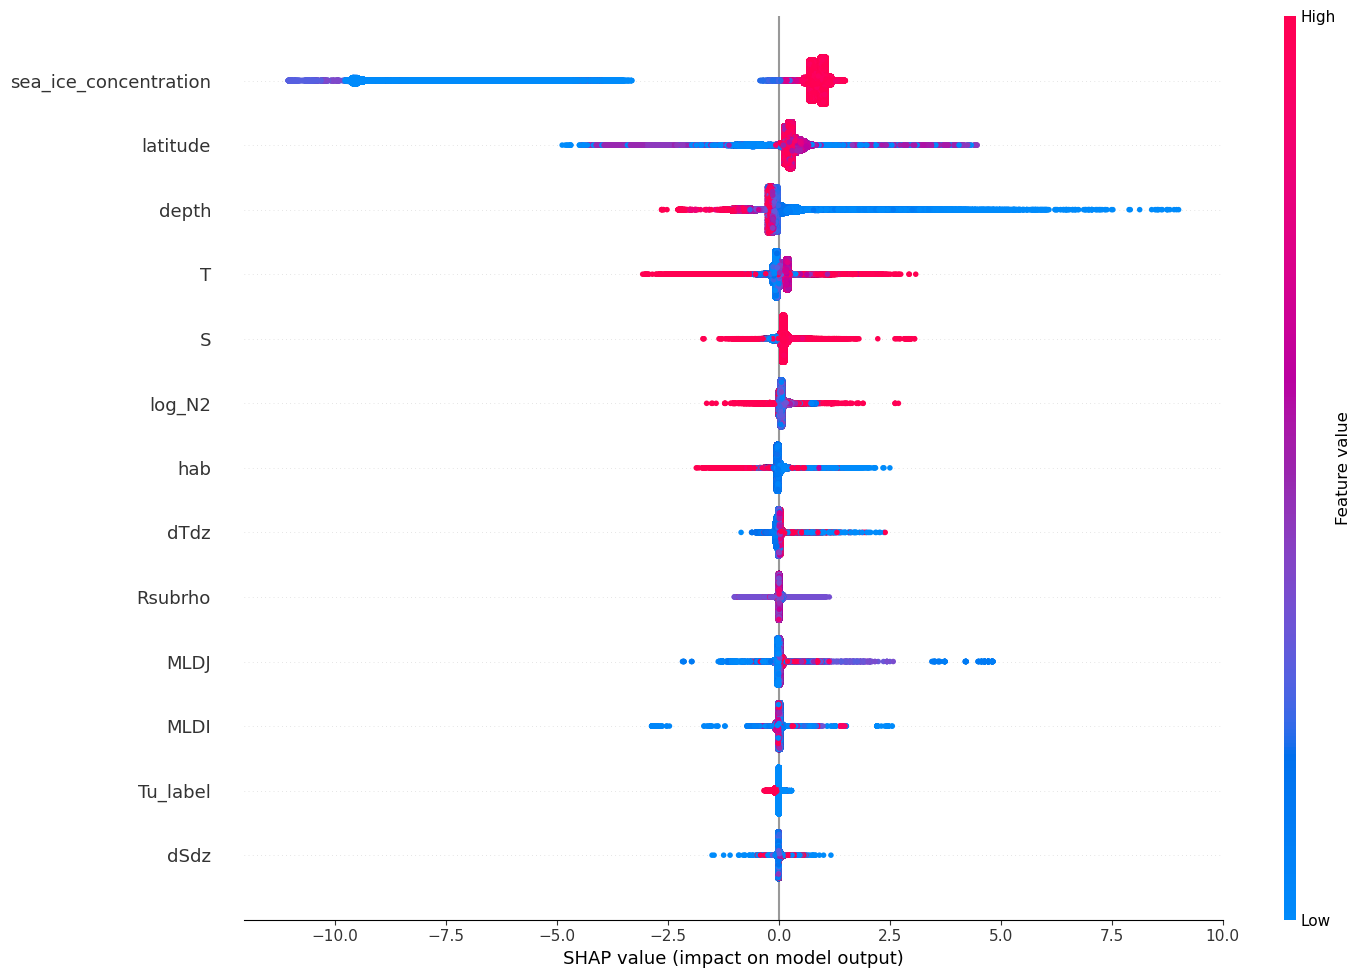

In [12]:
# excluded 'sea_ice_concentration','latitude', 
xstringlist_all_SIC = ['depth', 'hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'sea_ice_concentration', 'latitude']
ystringlist_all_SIC = ['log_eps']

plt_shap = shap.summary_plot(shap_values, #Use Shap values array
                             features=X_train, # Use training set features
                             feature_names=xstringlist_all_SIC, #Use column names
                             show=False, #Set to false to output to folder
                             plot_size=(15,10)) # Change plot size

# Save my figure to a directory
plt.savefig("plots/global_shap.png")

## Local force plots

In [14]:
# Predict on the test set
y_pred = model.predict(X_test)

In [15]:
# Reshape y_pred
y_pred = np.reshape(y_pred, (-1, 1))

X_test_df_SIC = pd.DataFrame(X_test, columns=xstringlist_all_SIC)
y_test_df_SIC = pd.DataFrame(Y_test, columns=ystringlist_all_SIC)
y_pred_df_SIC = pd.DataFrame(y_pred, columns=['eps_pred'])

SIC_all_testdf = create_testdf(X_test_df_SIC, y_test_df_SIC, y_pred_df_SIC)
#plot_residuals(arctic_all_testdf)

merged_df_SIC = SIC_all_testdf.merge(arctic_df, on=xstringlist_all_SIC+ystringlist_all_SIC)
merged_df_SIC = merged_df_SIC.drop_duplicates(subset=xstringlist_all_SIC+ystringlist_all_SIC)
residuals_SIC = (merged_df_SIC["log_eps"] - merged_df_SIC["eps_pred"])

ValueError: You are trying to merge on float64 and object columns. If you wish to proceed you should use pd.concat

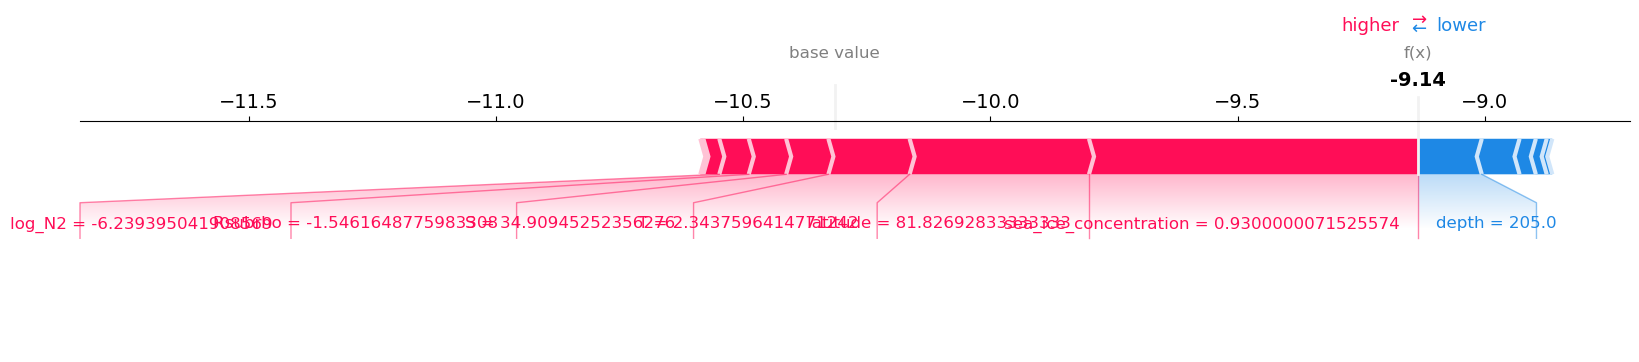

In [28]:
## Local analysis
obs_idx = 60000
local_plot = shap.force_plot(explainer.expected_value, 
                             shap_values[obs_idx], 
                 features=X_train[obs_idx],
                 feature_names=xstringlist_all_SIC,
                 show=False, matplotlib=True)
# Save my plot
plt.show(local_plot)

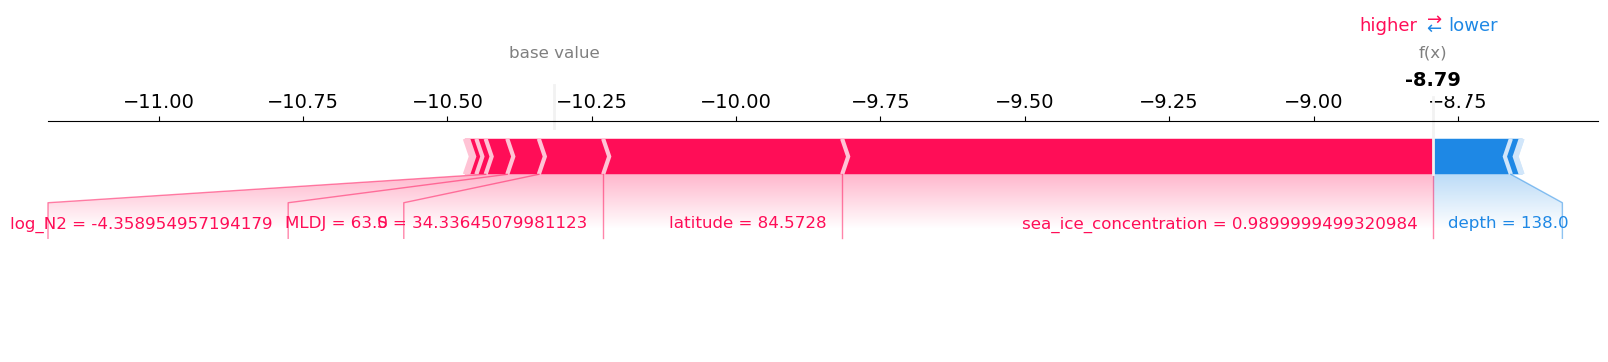

In [26]:
## Local analysis
obs_idx = 20000
local_plot = shap.force_plot(explainer.expected_value, 
                             shap_values[obs_idx], 
                 features=X_train[obs_idx],
                 feature_names=xstringlist_all_SIC,
                 show=False, matplotlib=True)
# Save my plot
plt.show(local_plot)

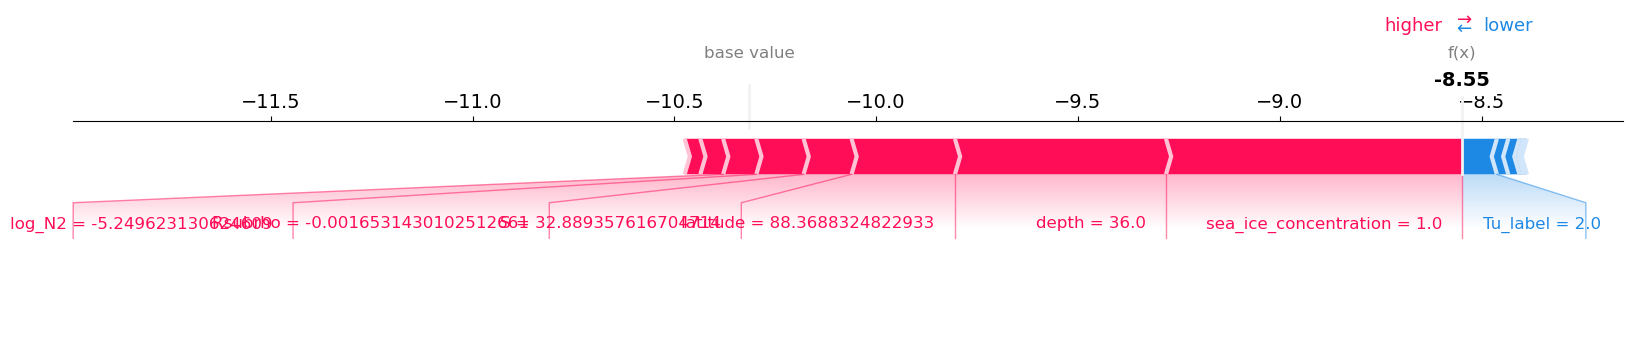

In [24]:
## Local analysis
obs_idx = 1000
local_plot = shap.force_plot(explainer.expected_value, 
                             shap_values[obs_idx], 
                 features=X_train[obs_idx],
                 feature_names=xstringlist_all_SIC,
                 show=False, matplotlib=True)
# Save my plot
plt.show(local_plot)

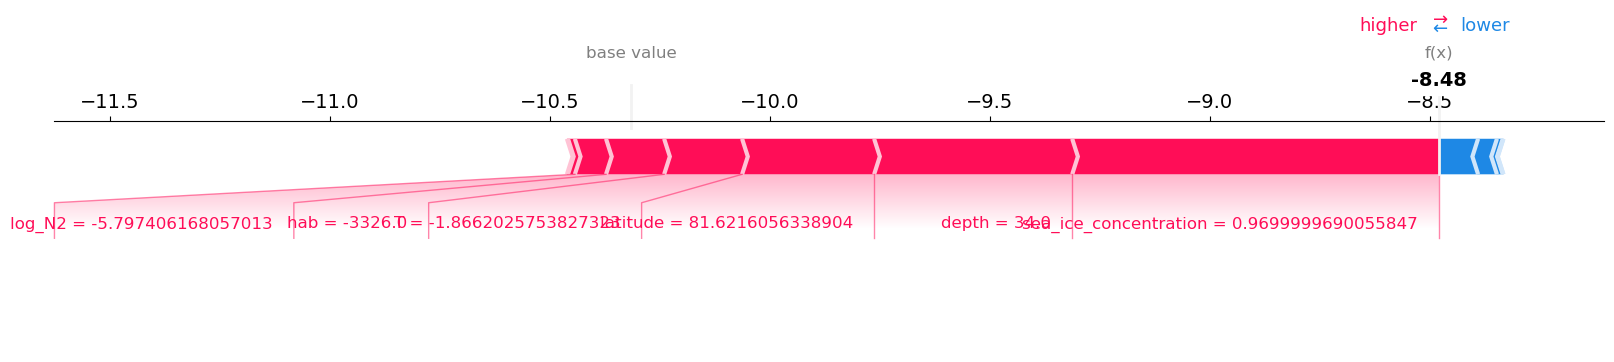

In [23]:
## Local analysis
obs_idx = 1
local_plot = shap.force_plot(explainer.expected_value, 
                             shap_values[obs_idx], 
                 features=X_train[obs_idx],
                 feature_names=xstringlist_all_SIC,
                 show=False, matplotlib=True)
# Save my plot
plt.show(local_plot)

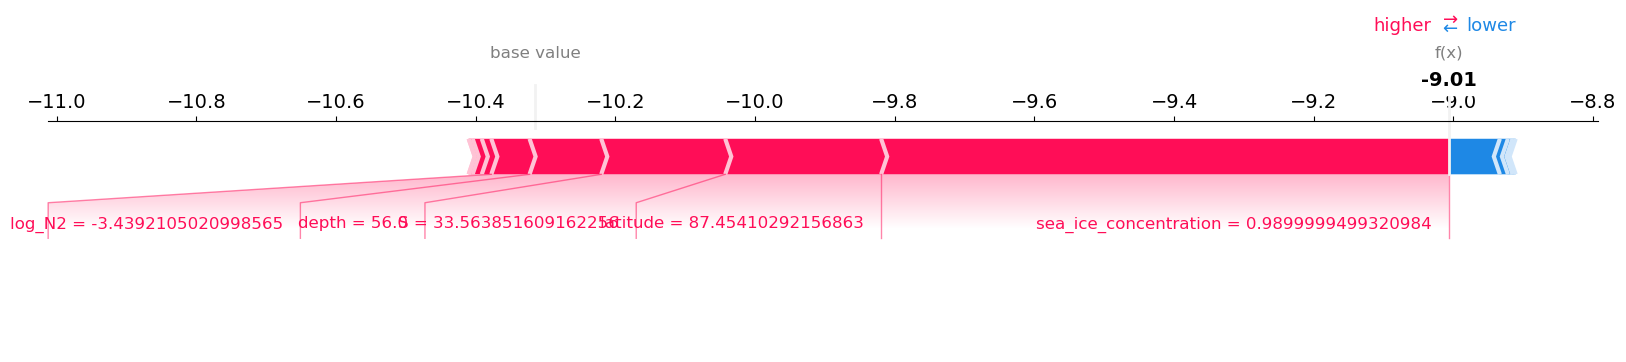

In [25]:
## Local analysis
obs_idx = 488
local_plot = shap.force_plot(explainer.expected_value, 
                             shap_values[obs_idx], 
                 features=X_train[obs_idx],
                 feature_names=xstringlist_all_SIC,
                 show=False, matplotlib=True)
# Save my plot
plt.show(local_plot)
#plt.savefig("plots/force_plot.png")

In [32]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

In [33]:
# Assign feature names to the shap_values object
shap_values.feature_names = xstringlist_all_SIC

The heatmap plot produced by shap.plots.heatmap() displays the SHAP values as a color-coded grid, where each row represents an instance, and each column represents a feature. The color of each cell in the grid represents the magnitude and direction of the SHAP value for a particular feature and instance.

The key aspects of interpreting the heatmap plot are as follows:

Color Intensity: The color intensity of a cell represents the magnitude of the SHAP value for a feature in an instance. Darker colors indicate higher positive or negative SHAP values, indicating a stronger influence of that feature on the model prediction.

Color Scale: The color scale or color bar displayed alongside the heatmap indicates the corresponding SHAP value range. It helps to interpret the intensity of the colors in the plot.

Feature Order: The columns in the heatmap correspond to the features, and their order matches the order of the features in the dataset. Each column represents the SHAP values for a specific feature across all instances.

Instance Order: The rows in the heatmap represent the instances, and their order corresponds to the order of instances in the input data. Each row shows the SHAP values for all features of a specific instance.

The heatmap plot allows you to identify the relative importance and impact of different features on model predictions across multiple instances. By observing patterns and color distributions in the heatmap, you can gain insights into how different features contribute to the model's output and understand their influence on individual predictions.

In [36]:
shap.plots.heatmap(shap_values[:10000])

## Shap values per region

In [6]:
# Extract values from the 12th column of batch 1
batch_1 = X_train[(X_train[:, 12] > 60) & (X_train[:, 12] <= 75)]
batch_2 = X_train[(X_train[:, 12] > 75) & (X_train[:, 12] <= 84)]
batch_3 = X_train[(X_train[:, 12] > 84) & (X_train[:, 12] <= 90)]

In [7]:
len(batch_1)

59880

In [8]:
len(batch_2)

123660

In [9]:
len(batch_3)

343408

In [11]:
# Fit relevant explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
# View shap values
print(shap_values)

In [12]:
# Compute Shapley values for each batch
explainer = shap.TreeExplainer(model)
shap_values_batch1 = explainer.shap_values(batch_1)
shap_values_batch2 = explainer.shap_values(batch_2)
shap_values_batch3 = explainer.shap_values(batch_3)

# Normalize the Shapley values within each batch
shap_values_batch1_normalized = (shap_values_batch1 - shap_values_batch1.mean()) / shap_values_batch1.std()
shap_values_batch2_normalized = (shap_values_batch2 - shap_values_batch2.mean()) / shap_values_batch2.std()
shap_values_batch3_normalized = (shap_values_batch3 - shap_values_batch3.mean()) / shap_values_batch3.std()

# Convert Shapley values to DataFrames
shap_values_batch1_df = pd.DataFrame(shap_values_batch1_normalized, columns=xstringlist_all_SIC)
shap_values_batch2_df = pd.DataFrame(shap_values_batch2_normalized, columns=xstringlist_all_SIC)
shap_values_batch3_df = pd.DataFrame(shap_values_batch3_normalized, columns=xstringlist_all_SIC)

<Figure size 1000x600 with 0 Axes>

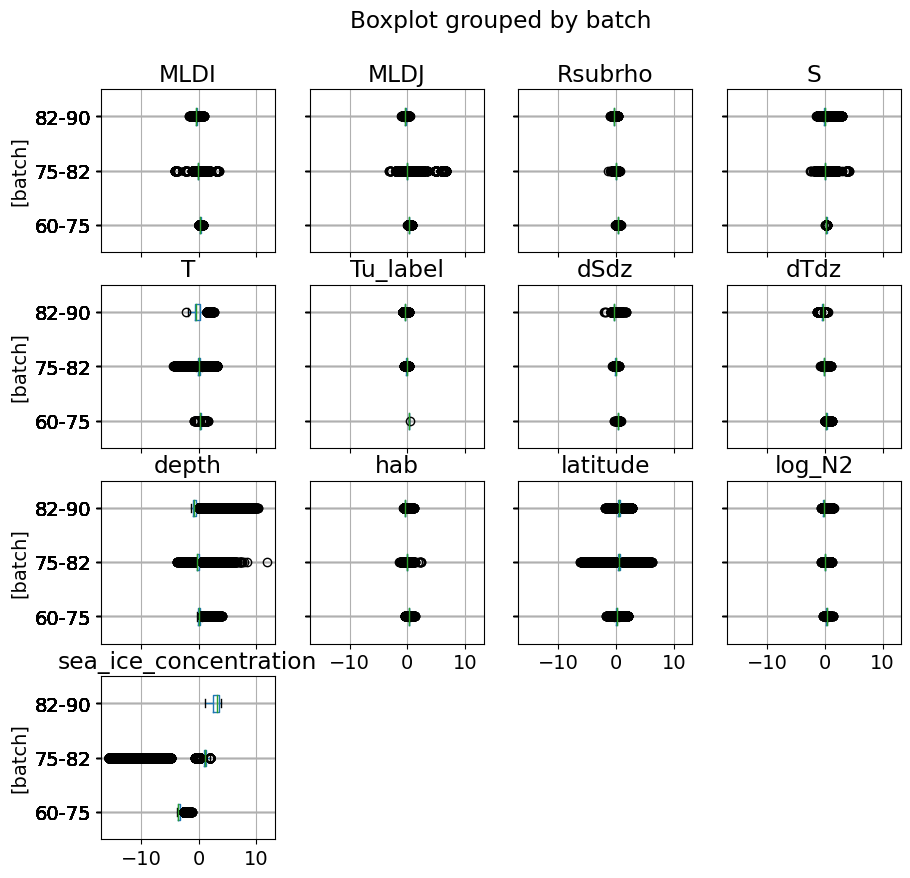

In [13]:
# Add 'batch' column to each DataFrame
shap_values_batch1_df['batch'] = '60-75'
shap_values_batch2_df['batch'] = '75-82'
shap_values_batch3_df['batch'] = '82-90'

# Concatenate the normalized Shapley values for comparison
shap_values_combined = pd.concat([shap_values_batch1_df, shap_values_batch2_df, shap_values_batch3_df])

# Plot box plots to compare Shapley values across batches
plt.figure(figsize=(10, 6))
shap_values_combined.boxplot(by="batch", vert=False)
plt.title("Comparison of Shapley Values across Batches")
plt.xlabel("Shapley Value")
plt.ylabel("Batch")
plt.show()

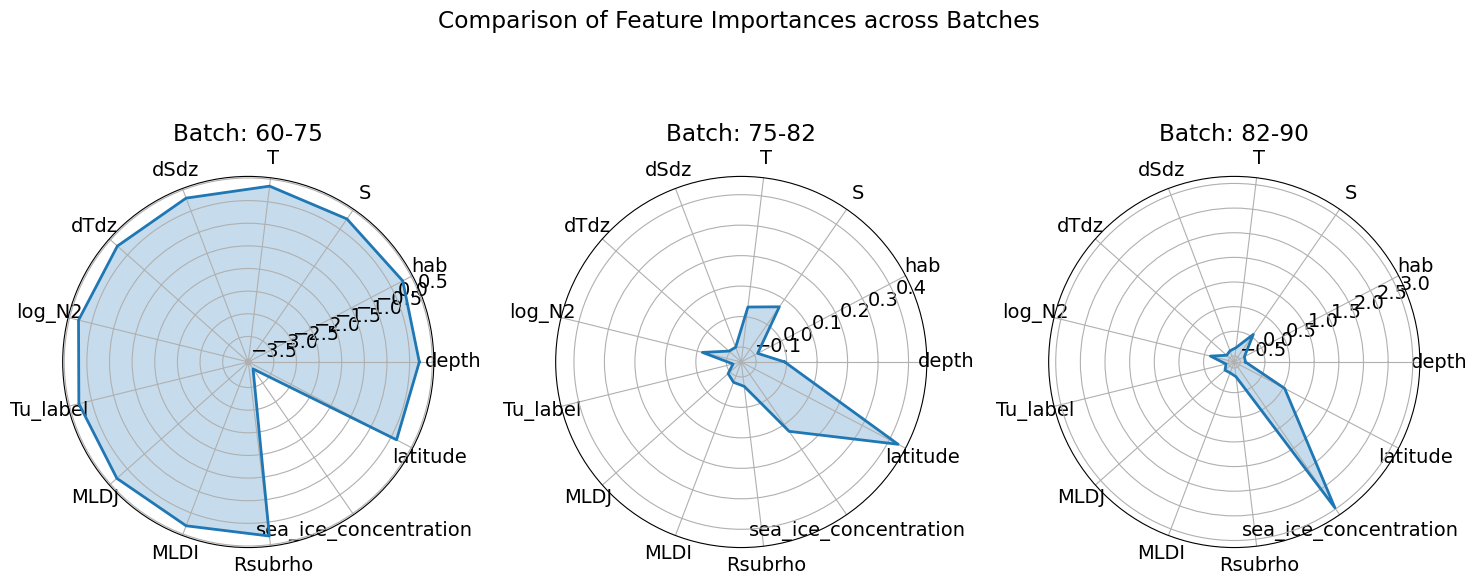

In [14]:
# Define the features
features = shap_values_combined.columns[:-1]  # Exclude 'batch' column

# Plot radar charts for each batch
num_batches = shap_values_combined['batch'].nunique()
fig, axs = plt.subplots(nrows=1, ncols=num_batches, figsize=(15, 6), subplot_kw=dict(polar=True))

for i, (batch, ax) in enumerate(zip(shap_values_combined['batch'].unique(), axs.flatten())):
    batch_values = shap_values_combined.loc[shap_values_combined['batch'] == batch, features].mean().values
    values = np.concatenate((batch_values, [batch_values[0]]))
    angles = np.linspace(0, 2 * np.pi, len(features) + 1, endpoint=True)

    ax.plot(angles, values, linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features)
    ax.set_title(f'Batch: {batch}')

plt.suptitle("Comparison of Feature Importances across Batches", y=1.05)
plt.tight_layout()
plt.show()


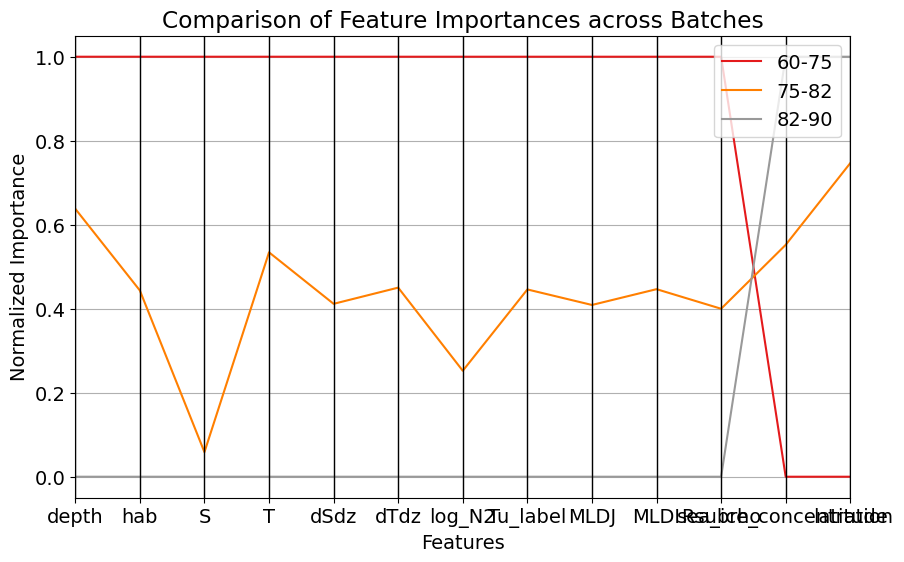

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import parallel_coordinates

# Group the Shapley values by batch and calculate the mean for each feature
average_feature_importances = shap_values_combined.groupby(['batch']).mean().reset_index()

# Remove the 'batch' column from the DataFrame
average_feature_importances = average_feature_importances.drop('batch', axis=1)

# Normalize the feature importances for each batch
normalized_feature_importances = (average_feature_importances - average_feature_importances.min()) / (
        average_feature_importances.max() - average_feature_importances.min())

# Add the 'batch' column back to the normalized DataFrame
normalized_feature_importances['batch'] = ['60-75', '75-82', '82-90']

# Set the 'batch' column as the first column
cols = normalized_feature_importances.columns.tolist()
cols = cols[-1:] + cols[:-1]
normalized_feature_importances = normalized_feature_importances[cols]

# Create the parallel coordinate plot
plt.figure(figsize=(10, 6))
parallel_coordinates(normalized_feature_importances, 'batch', colormap='Set1')

# Set the title and labels
plt.title('Comparison of Feature Importances across Batches')
plt.xlabel('Features')
plt.ylabel('Normalized Importance')

# Show the plot
plt.show()



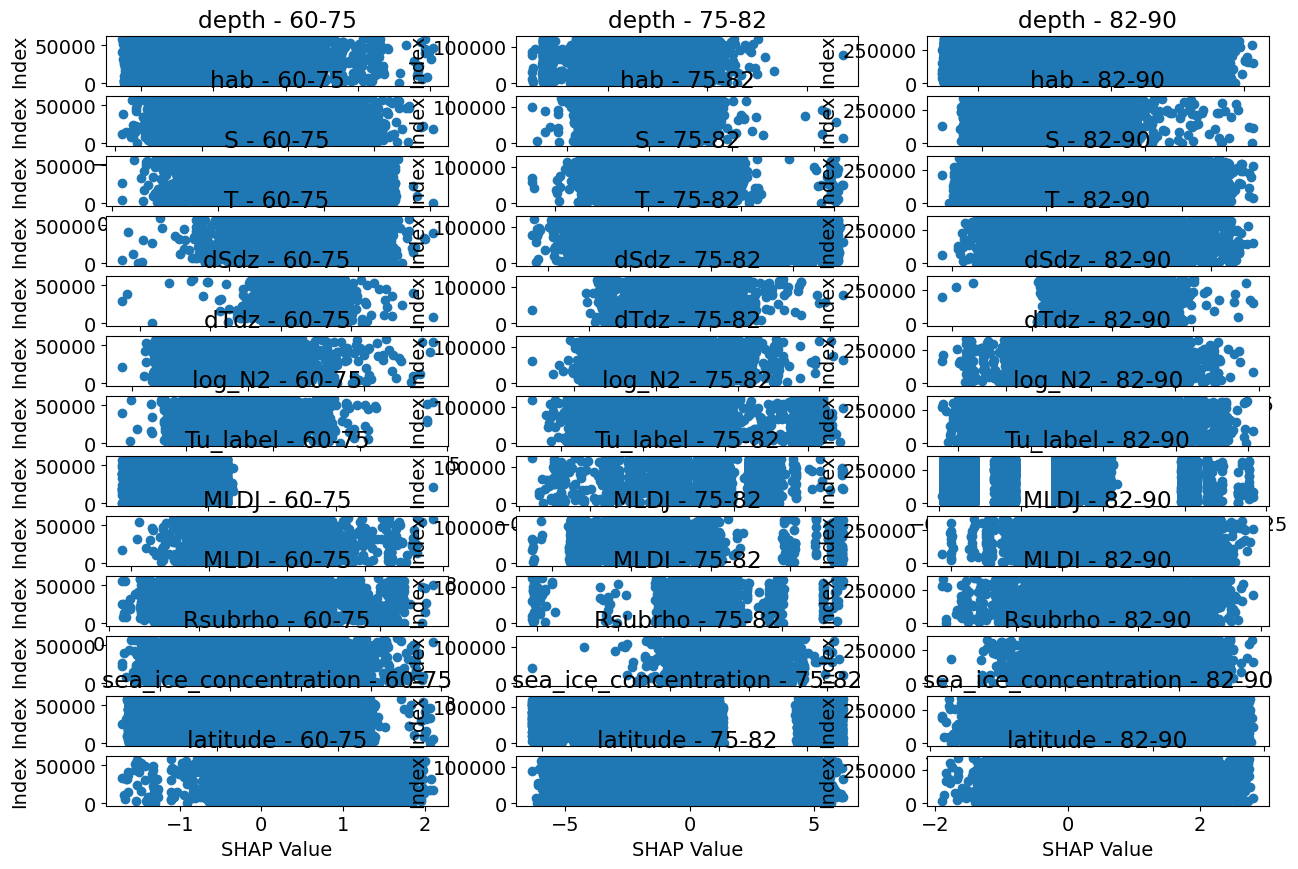

In [16]:
import matplotlib.pyplot as plt

# Group the SHAP values by batch
grouped_shap_values = shap_values_combined.groupby('batch')

# Get the list of features
features = shap_values_combined.columns[:-1]  # Exclude the 'batch' column

# Define the number of rows and columns for subplots
num_features = len(features)
num_batches = len(shap_values_combined['batch'].unique())
num_rows = num_features
num_cols = num_batches

# Create subplots for each feature
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Iterate through each feature
for i, feature in enumerate(features):
    # Iterate through each batch
    for j, batch in enumerate(shap_values_combined['batch'].unique()):
        # Extract the SHAP values for the current feature and batch
        shap_values = grouped_shap_values.get_group(batch)[feature]

        # Plot the scatter plot for the current feature and batch
        ax = axes[i, j] if num_features > 1 else axes[j]
        ax.scatter(shap_values, shap_values.index)
        ax.set_title(f'{feature} - {batch}')
        ax.set_xlabel('SHAP Value')
        ax.set_ylabel('Index')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()



In [18]:
import matplotlib.pyplot as plt

# Define the features of interest
features_of_interest = ['sea_ice_concentration', 'Rsubrho', 'Salinity']

# Iterate through each batch
for batch in shap_values_combined['batch'].unique():
    # Filter the data for the current batch
    batch_data = shap_values_combined[shap_values_combined['batch'] == batch]
    
    # Create a separate scatter plot for each feature
    for feature in features_of_interest:
        # Extract the feature values and the corresponding SHAP values
        x = batch_data[feature]
        y = batch_data['shap_value']
        
        # Create the scatter plot
        plt.figure(figsize=(8, 6))
        plt.scatter(x, y, alpha=0.8)
        
        # Set labels and title
        plt.xlabel(feature)
        plt.ylabel('SHAP Value')
        plt.title(f'Scatter Plot: SHAP Value vs {feature} - Batch {batch}')
        
        # Show how higher/lower values impact the prediction
        if feature == 'sea_ice_concentration':
            plt.axvline(x=0.5, color='red', linestyle='--', label='Higher')
            plt.axvline(x=0.2, color='blue', linestyle='--', label='Lower')
        
        # Add legend
        plt.legend()
        
        # Show the plot
        plt.show()


KeyError: 'shap_value'

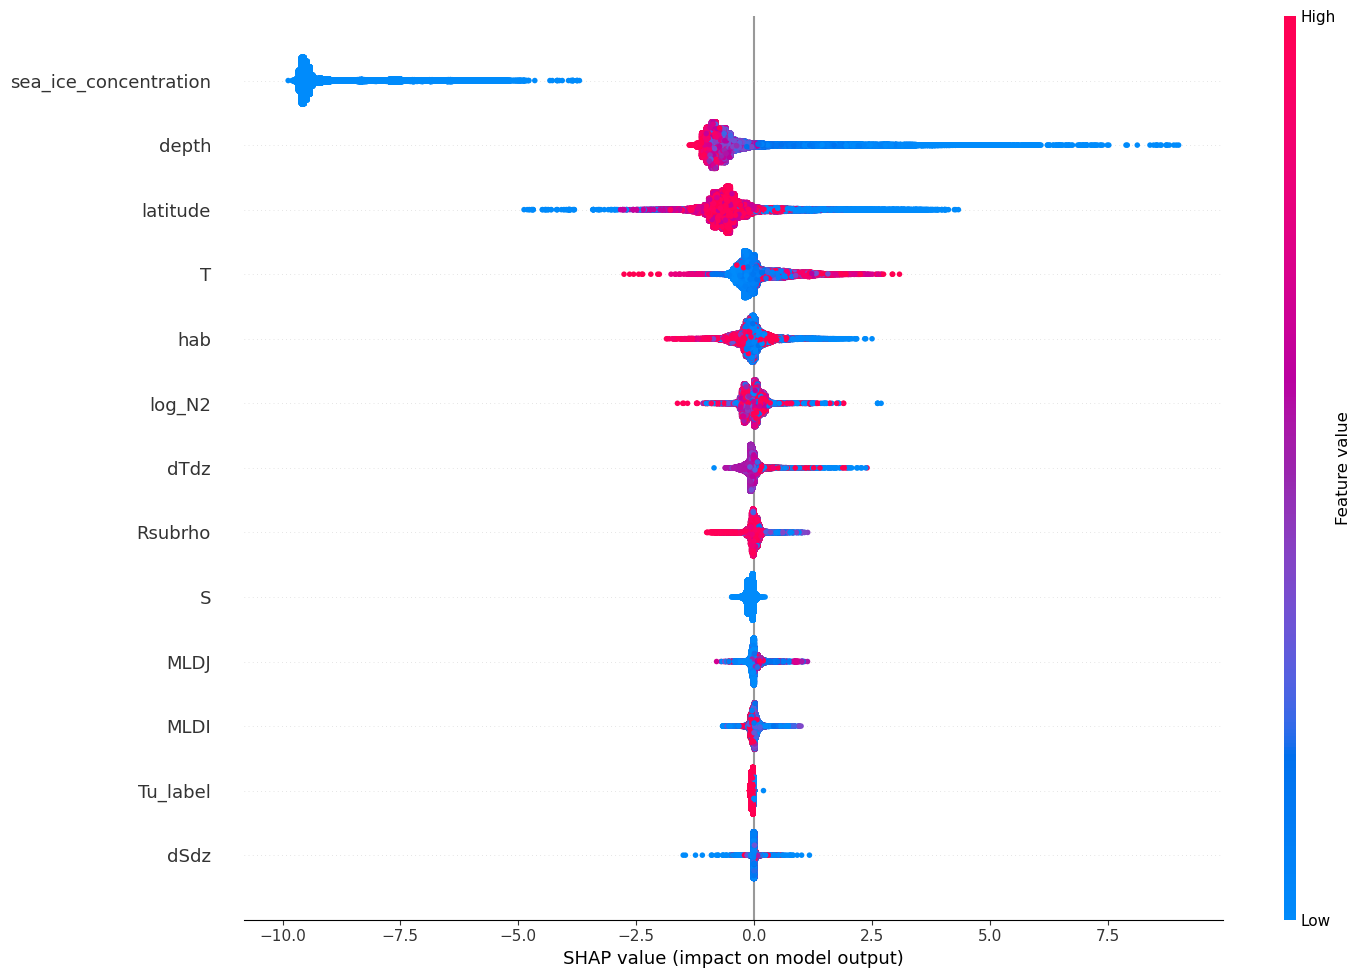

In [22]:
xstringlist_all_SIC = ['depth', 'hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'sea_ice_concentration', 'latitude']
ystringlist_all_SIC = ['log_eps']

plt_shap = shap.summary_plot(shap_values_batch1, #Use Shap values array
                             features=batch_1, # Use training set features
                             feature_names=xstringlist_all_SIC, #Use column names
                             show=False, #Set to false to output to folder
                             plot_size=(15,10)) # Change plot size

# Save my figure to a directory
plt.savefig("plots/batch1_shap.png")

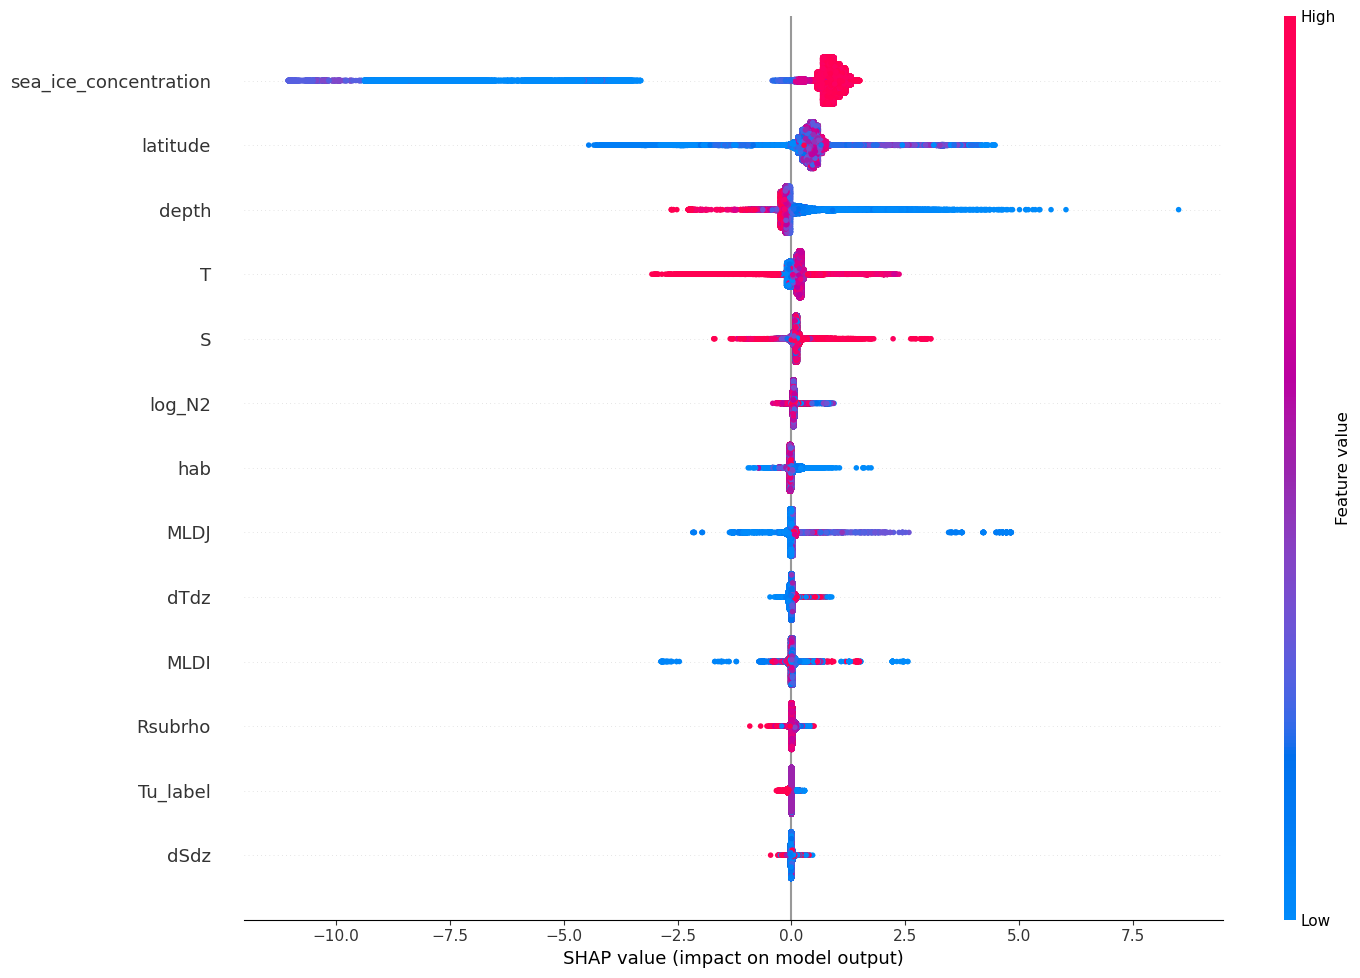

In [23]:
xstringlist_all_SIC = ['depth', 'hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'sea_ice_concentration', 'latitude']
ystringlist_all_SIC = ['log_eps']

plt_shap = shap.summary_plot(shap_values_batch2, #Use Shap values array
                             features=batch_2, # Use training set features
                             feature_names=xstringlist_all_SIC, #Use column names
                             show=False, #Set to false to output to folder
                             plot_size=(15,10)) # Change plot size

# Save my figure to a directory
plt.savefig("plots/batch2_shap.png")

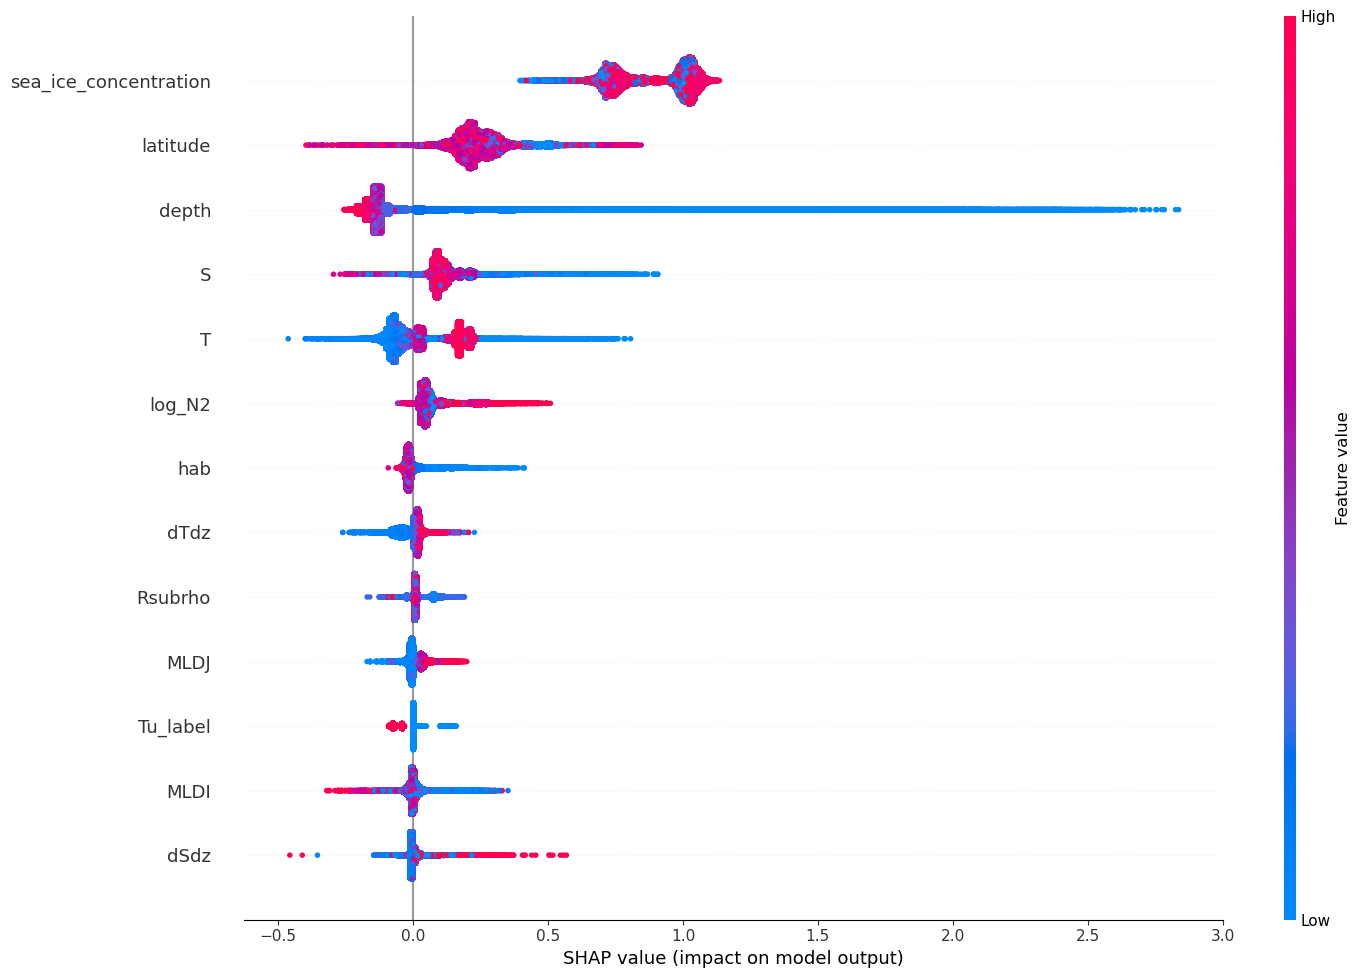

In [21]:
xstringlist_all_SIC = ['depth', 'hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'sea_ice_concentration', 'latitude']
ystringlist_all_SIC = ['log_eps']

plt_shap = shap.summary_plot(shap_values_batch3, #Use Shap values array
                             features=batch_3, # Use training set features
                             feature_names=xstringlist_all_SIC, #Use column names
                             show=False, #Set to false to output to folder
                             plot_size=(15,10)) # Change plot size

# Save my figure to a directory
plt.savefig("plots/batch3_shap.png")


The Shapley summary plot is a visualization that provides an overview of the feature importance based on the Shapley values. It helps in understanding how each feature contributes to the model's output and their relative importance.

In a Shapley summary plot, the features are sorted in descending order based on their average absolute Shapley values. The plot consists of horizontal bars representing each feature, with the length of the bar indicating the magnitude of the feature's average Shapley value. The bars are color-coded based on the sign of the Shapley value, where positive values are displayed in blue and negative values in red.

Here's how to interpret a Shapley summary plot:

Feature Importance: The vertical axis represents the features. Features at the top have higher average absolute Shapley values and contribute more to the model's output.

Shapley Value Magnitude: The horizontal axis represents the average absolute Shapley values. The longer the bar for a feature, the more it influences the model's predictions. Features with longer bars are considered more important.

Sign of Shapley Values: The color of the bars indicates the sign of the Shapley values. Blue bars represent positive Shapley values, indicating that the feature positively contributes to the prediction. Red bars represent negative Shapley values, indicating a negative contribution to the prediction.

Comparative Analysis: By comparing the lengths of the bars, you can identify the most influential features. Longer bars indicate stronger contributions, while shorter bars have relatively lesser impact.

Interaction Effects: If two features are close to each other and have similar lengths, it suggests they may interact with each other to influence the predictions.

### shapley test for depth

In [26]:
# Extract values from the 12th column of batch 1
batch_1 = X_train[(X_train[:, 0] > 0 ) & (X_train[:, 0] <= 100)]
batch_2 = X_train[(X_train[:, 0] > 100) & (X_train[:, 12] <= 2000)]

In [27]:
# Compute Shapley values for each batch
explainer = shap.TreeExplainer(model)
shap_values_batch1 = explainer.shap_values(batch_1)
shap_values_batch2 = explainer.shap_values(batch_2)

# Normalize the Shapley values within each batch
shap_values_batch1_normalized = (shap_values_batch1 - shap_values_batch1.mean()) / shap_values_batch1.std()
shap_values_batch2_normalized = (shap_values_batch2 - shap_values_batch2.mean()) / shap_values_batch2.std()

# Convert Shapley values to DataFrames
shap_values_batch1_df = pd.DataFrame(shap_values_batch1_normalized, columns=xstringlist_all_SIC)
shap_values_batch2_df = pd.DataFrame(shap_values_batch2_normalized, columns=xstringlist_all_SIC)

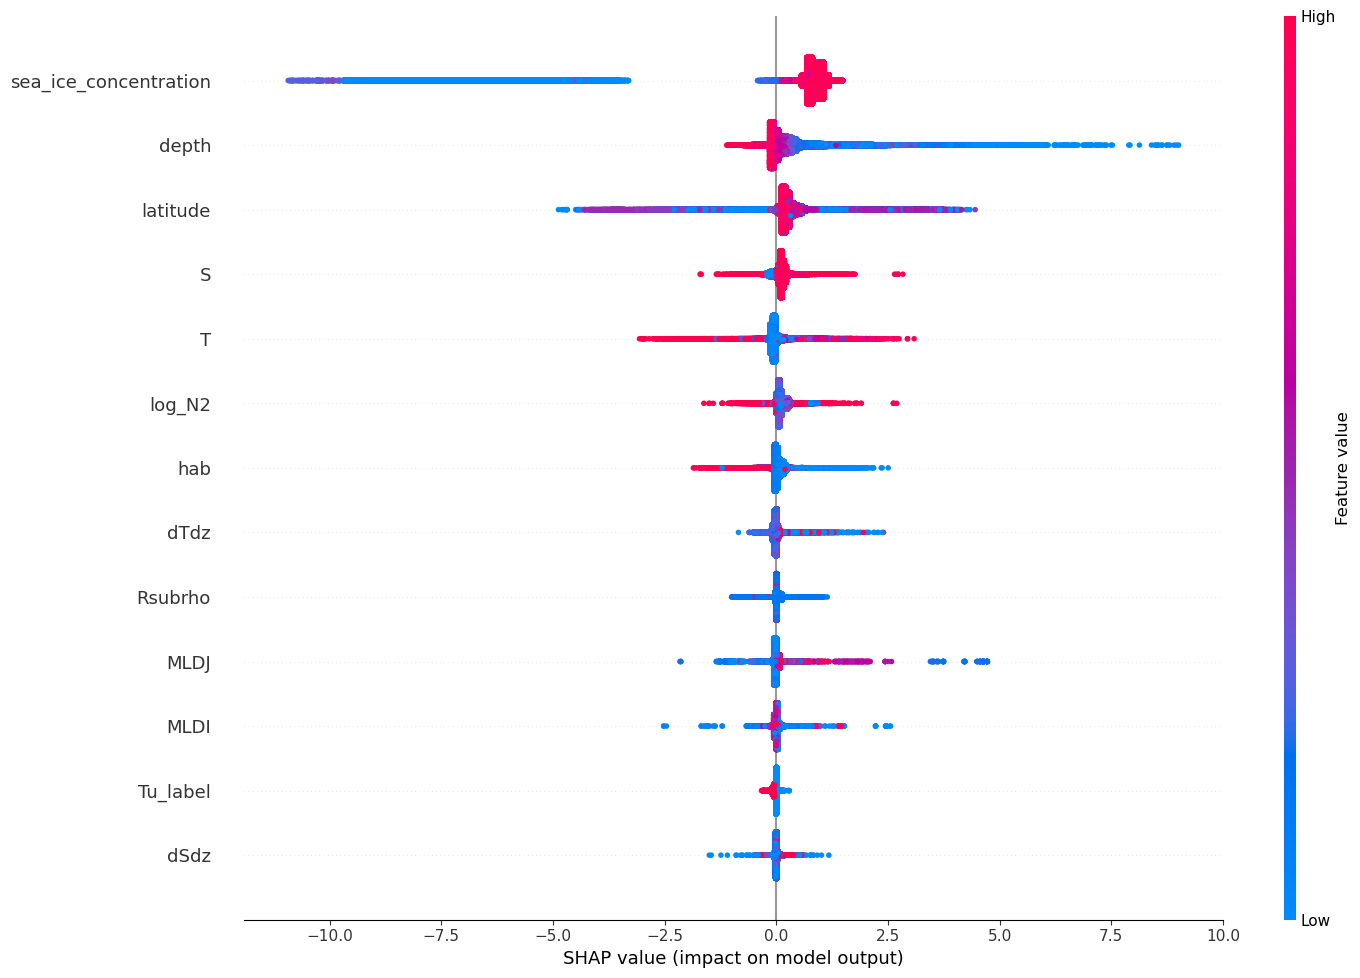

In [29]:
xstringlist_all_SIC = ['depth', 'hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'sea_ice_concentration', 'latitude']
ystringlist_all_SIC = ['log_eps']

plt_shap = shap.summary_plot(shap_values_batch1, #Use Shap values array
                             features=batch_1, # Use training set features
                             feature_names=xstringlist_all_SIC, #Use column names
                             show=False, #Set to false to output to folder
                             plot_size=(15,10)) # Change plot size

# Save my figure to a directory
plt.savefig("plots/batch1_depth_shap.png")

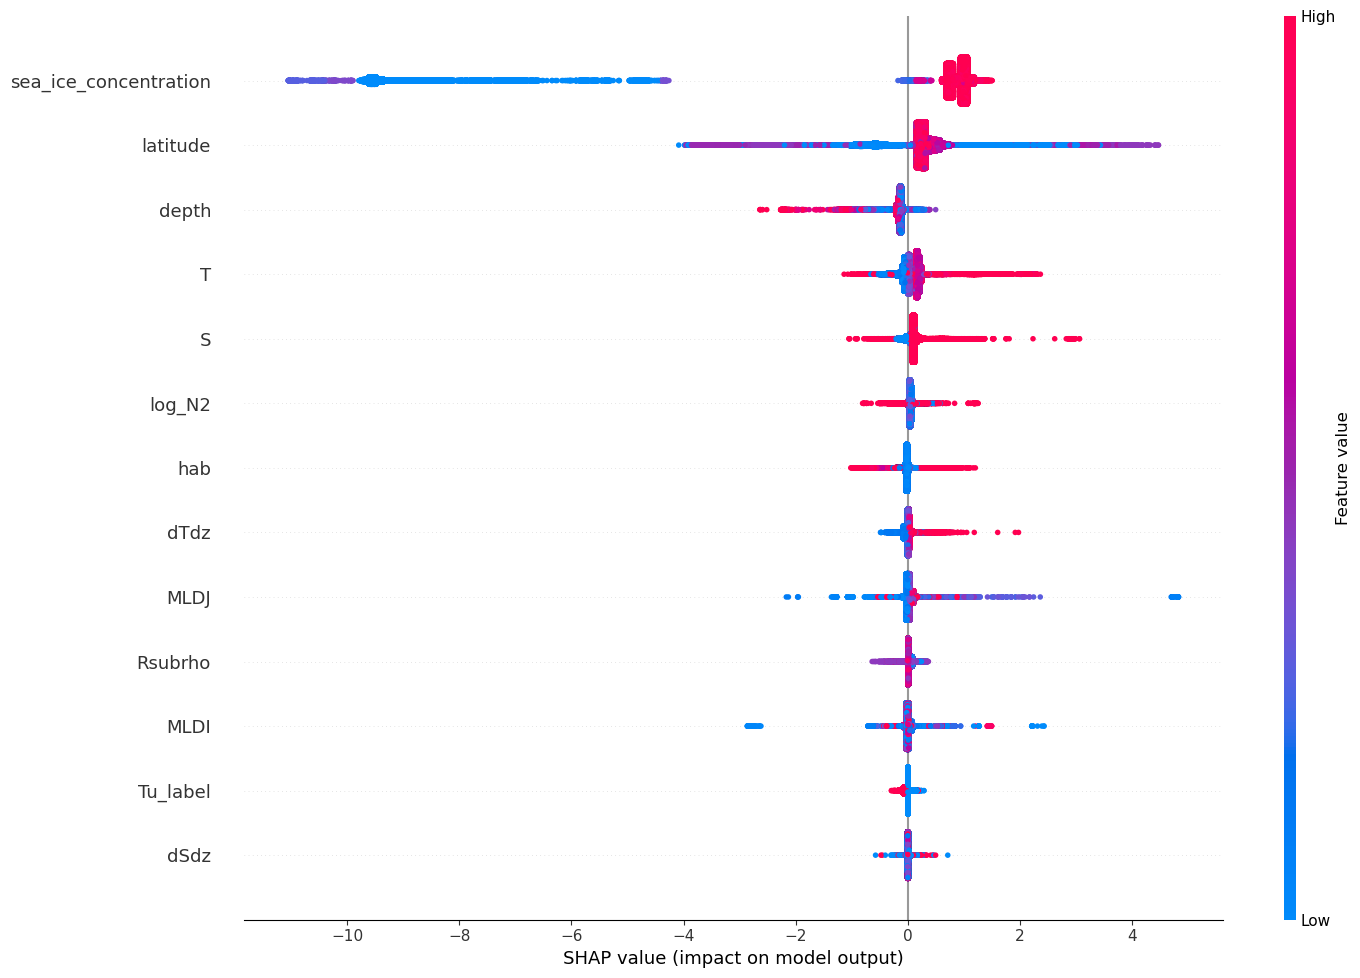

In [28]:
xstringlist_all_SIC = ['depth', 'hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'sea_ice_concentration', 'latitude']
ystringlist_all_SIC = ['log_eps']

plt_shap = shap.summary_plot(shap_values_batch2, #Use Shap values array
                             features=batch_2, # Use training set features
                             feature_names=xstringlist_all_SIC, #Use column names
                             show=False, #Set to false to output to folder
                             plot_size=(15,10)) # Change plot size

# Save my figure to a directory
plt.savefig("plots/batch2_depth_shap.png")